In [1]:
import sys, os
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))
from src.LogViewer import LogViewer
from src.utils import SingleModelTrainingProcess
from src.Mydataloader import LoadDataset

In [2]:
ReduceLROnPlateau_patiance = 5
ReduceLROnPlateau_cooldown = 5

# %%
"""Dataset selection"""
# DATASET = "CIFAR10"
# DATASET = "CIFAR100"
DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 256

"""optimizer parameters"""
optim_list = [
    # "Adam",
    # "Adam_decay",
    "SGD",
    # "SGD_nasterov",
    # "AdamW",
    # "AdamW_amsgrad",
    "NAdam",
]
PRINT_PAD_OPTIM = max([len(i) for i in optim_list])

scheduler_list = [
    # "ExponentialLR",
    "MultiStepLR",
    "ReduceLROnPlateau",
    # "CosineAnnealingLR",
    # "CosineAnnealingWarmUpRestarts",
    # "CycleLR",
    # "ConstantLR",
]
PRINT_PAD_SCHDULER = max([len(i) for i in scheduler_list])

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 150

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 15

tmp = LoadDataset(root="../../data", seceted_dataset=DATASET)
_, _, _, _ = tmp.Unpack()


train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    pin_memory_device="cuda",
    persistent_workers=True,
)
print("-" * 50)

-----------------------------------------------------------------------
Dataset :  ImageNet2012
- Length of Train Set :  1281167
- Length of Valid Set :  50000
- Count of Classes :  1000
-----------------------------------------------------------------------
train.transforms = Compose(
      RandomShortestSize(min_size=[256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391

In [3]:
each_trainings = []
# for optim in optim_list:
#     for scheduler in scheduler_list:
#         each_trainings.append(SingleModelTrainingProcess(optim, scheduler))

In [4]:
# each_trainings.append(
#     SingleModelTrainingProcess(
#         dataset=DATASET,
#         batch_size=BATCH,
#         optimizer_name="NAdam",
#         schduler_name="ReduceLROnPlateau",
#         device="cuda",
#         train_dataloader=train_dataloader,
#         valid_dataloader=valid_dataloader,
#         test_dataloader=test_dataloader,
#         Earlystopping_patiance=-1,
#         ReduceLROnPlateau_patiance=ReduceLROnPlateau_patiance,
#         ReduceLROnPlateau_cooldown=ReduceLROnPlateau_cooldown,
#     )
# )
print("-" * 50)
each_trainings.append(
    SingleModelTrainingProcess(
        dataset=DATASET,
        batch_size=BATCH,
        optimizer_name="NAdam",
        schduler_name="MultiStepLR",
        device="cuda",
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        test_dataloader=test_dataloader,
        Earlystopping_patiance=15,
    )
)
print("-" * 50)
each_trainings.append(
    SingleModelTrainingProcess(
        dataset=DATASET,
        batch_size=BATCH,
        optimizer_name="SGD",
        schduler_name="MultiStepLR",
        device="cuda",
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        test_dataloader=test_dataloader,
        Earlystopping_patiance=15,
    )
)
print("-" * 50)

--------------------------------------------------
Suceessfully loaded the All setting and Log file.
MyResNet34_256_NAdam_MultiStepLR
Current epoch is 110
Current learning rate: 2e-05
Current best valid loss: 3.1306022539430733
Current best model loss: 3.1306022539430733
--------------------------------------------------
Suceessfully loaded the All setting and Log file.
MyResNet34_256_SGD_MultiStepLR
Current epoch is 110
Current learning rate: 0.0010000000000000002
Current best valid loss: 1.3550978181313496
Current best model loss: 1.3550978181313496
--------------------------------------------------


1 epoch: train_loss=5.9449, train_acc=0.0340, valid_loss=5.0849, valid_acc=0.0839, lr=0.0020
2 epoch: train_loss=4.9737, train_acc=0.0997, valid_loss=4.7265, valid_acc=0.1319, lr=0.0020
3 epoch: train_loss=4.6762, train_acc=0.1313, valid_loss=4.3907, valid_acc=0.1719, lr=0.0020
4 epoch: train_loss=4.5279, train_acc=0.1493, valid_loss=4.2832, valid_acc=0.1899, lr=0.0020
5 epoch: train_loss=4.4377, train_acc=0.1595, valid_loss=4.2105, valid_acc=0.1997, lr=0.0020
6 epoch: train_loss=4.3759, train_acc=0.1684, valid_loss=4.1146, valid_acc=0.2130, lr=0.0020
7 epoch: train_loss=4.3340, train_acc=0.1728, valid_loss=4.2538, valid_acc=0.2156, lr=0.0020
8 epoch: train_loss=4.2976, train_acc=0.1777, valid_loss=4.1170, valid_acc=0.2263, lr=0.0020
9 epoch: train_loss=4.2702, train_acc=0.1816, valid_loss=4.0920, valid_acc=0.2314, lr=0.0020
10 epoch: train_loss=4.2469, train_acc=0.1840, valid_loss=4.1721, valid_acc=0.2263, lr=0.0020
11 epoch: train_loss=4.2315, train_acc=0.1863, valid_loss=4.2156, val

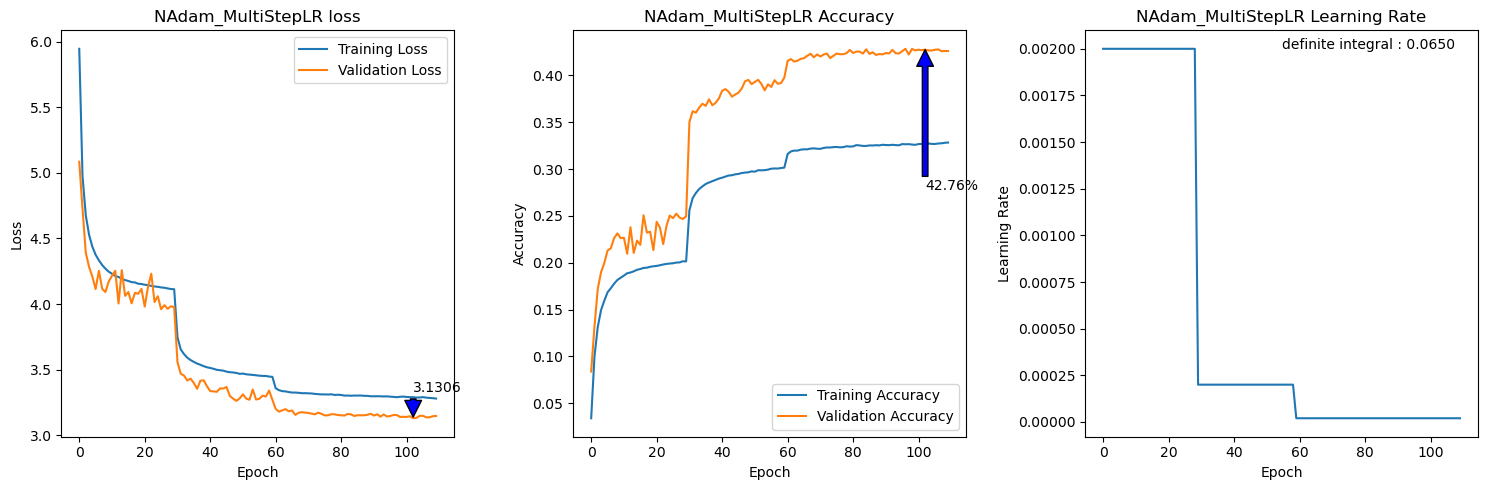

NAdam_MultiStepLR
now_lr:  2e-05
1 epoch: train_loss=6.0621, train_acc=0.0286, valid_loss=5.1182, valid_acc=0.0854, lr=0.1000
2 epoch: train_loss=4.6831, train_acc=0.1292, valid_loss=4.0585, valid_acc=0.2227, lr=0.1000
3 epoch: train_loss=4.0363, train_acc=0.2089, valid_loss=3.3819, valid_acc=0.3203, lr=0.1000
4 epoch: train_loss=3.7119, train_acc=0.2556, valid_loss=3.1517, valid_acc=0.3597, lr=0.1000
5 epoch: train_loss=3.5304, train_acc=0.2826, valid_loss=3.0723, valid_acc=0.3852, lr=0.1000
6 epoch: train_loss=3.4163, train_acc=0.3008, valid_loss=2.9569, valid_acc=0.3944, lr=0.1000
7 epoch: train_loss=3.3415, train_acc=0.3124, valid_loss=2.8709, valid_acc=0.4231, lr=0.1000
8 epoch: train_loss=3.2840, train_acc=0.3220, valid_loss=2.9351, valid_acc=0.4161, lr=0.1000
9 epoch: train_loss=3.2433, train_acc=0.3282, valid_loss=2.8143, valid_acc=0.4366, lr=0.1000
10 epoch: train_loss=3.2097, train_acc=0.3335, valid_loss=2.8044, valid_acc=0.4370, lr=0.1000
11 epoch: train_loss=3.1845, train_a

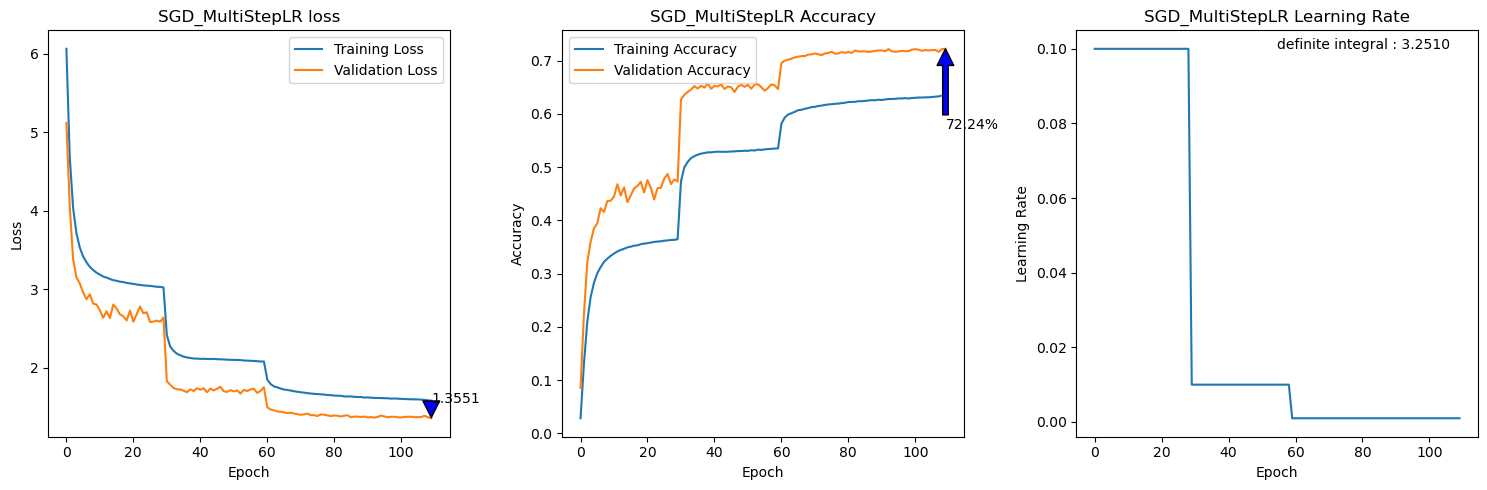

SGD_MultiStepLR
now_lr:  0.0010000000000000002


In [5]:
for training in each_trainings:
    viewer = LogViewer(training.logs)
    viewer.print_all()
    viewer.draw(
        title=training.optimizer_name + "_" + training.scheduler_name,
        min_marker=True,
        save=True,
        add_lr_plot=True,
    )
    print(training.optimizer_name + "_" + training.scheduler_name)
    if training.scheduler_name == "ReduceLROnPlateau":
        print(training.scheduler.num_bad_epochs)
        print(training.scheduler.cooldown_counter)
        print(training.scheduler.patience)

    print("now_lr: ", training.optimizer.param_groups[0]["lr"])

In [6]:
# for training in each_trainings:
#     # training.logs["train_loss"] = training.logs["train_loss"][:108]
#     # training.logs["train_acc"] = training.logs["train_acc"][:108]
#     # training.logs["valid_loss"] = training.logs["valid_loss"][:108]
#     # training.logs["valid_acc"] = training.logs["valid_acc"][:108]
#     # training.logs["test_loss"] = training.logs["test_loss"][:108]
#     # training.logs["test_acc"] = training.logs["test_acc"][:108]
#     # training.logs["lr_log"] = training.logs["lr_log"][:108]
#     training.save_model()

In [7]:
# import numpy as np
# print(np.min(each_trainings[0].logs["valid_loss"]))
# print(np.min(each_trainings[1].logs["valid_loss"]))

In [8]:
# each_trainings[0].earlystopper.best_eval_loss = 3.1306022539430733
# each_trainings[1].earlystopper.best_eval_loss = 1.3550978181313496

In [9]:
# # each_trainings[0].save_model()
# # each_trainings[1].save_model()
# import torch
# torch.save(each_trainings[0].model.state_dict(), each_trainings[0].file_name + ".pth")
# torch.save(each_trainings[1].model.state_dict(), each_trainings[1].file_name + ".pth")

In [10]:
print(each_trainings[0].earlystopper.best_eval_loss)
print(each_trainings[1].earlystopper.best_eval_loss)

3.1306022539430733
1.3550978181313496


In [11]:
# each_trainings[1].save_model()

In [16]:
print(each_trainings[0].earlystopper.early_stop_counter)
print(each_trainings[1].earlystopper.early_stop_counter)
print(each_trainings[0].earlystopper.PATIENCE)
print(each_trainings[1].earlystopper.PATIENCE)
print(each_trainings[0].earlystopper.end_flag)
print(each_trainings[1].earlystopper.end_flag)

1
5
15
15
False
False
